In [9]:
from data_preprocessing import *
from clustering import *
from strategy import *

In [10]:
## Data file for the demo
demo_filename = "data/demo.tar"
## Actual data file
actual_filename = "data/period_data.tar"

First, we explore the provided data; how many minutes of data are we missing for the period ? We chose to remove stocks that had more than 25% of data missing for the period. 

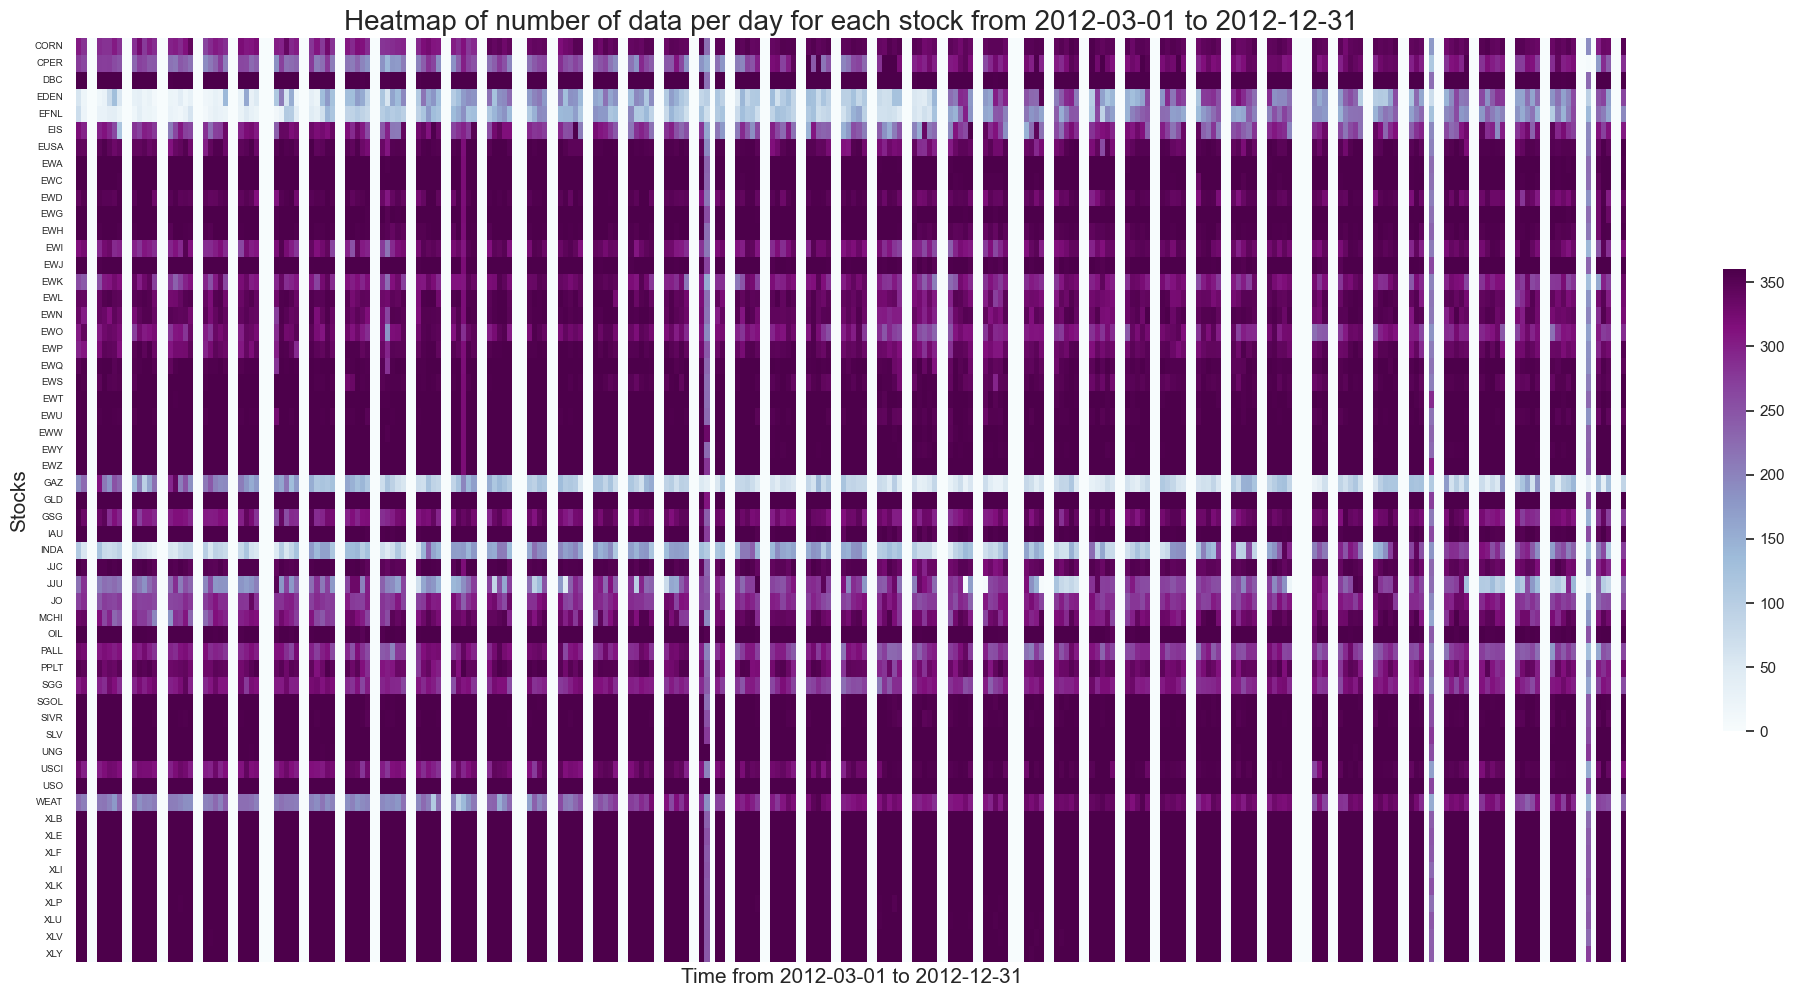

We remove the 6 stocks with more than 25% missing minutes: EDEN, EFNL, GAZ, INDA, JJU, WEAT
We are now working with : 49 stocks.
The missing minutes values were now filled.


In [11]:
period_data = preprocessing(actual_filename)

Then, based on our data, we compute the Louvain clustering algorithm to obtain our daily market states. 

Daily data shape: (168, 17640)
There are 5 clusters
The length of each clusters are Cluster
0    12
1     4
2    82
3    10
4    60
dtype: int64


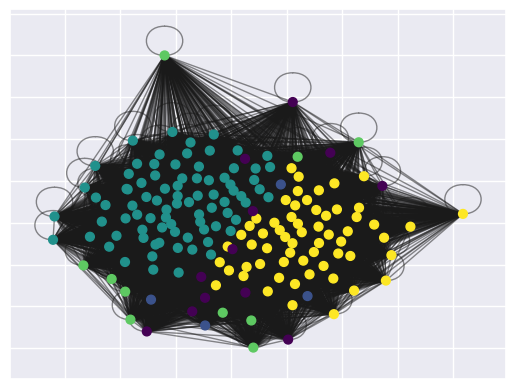

2012-10-31
The new day is assigned to cluster 1 with similarity 0.008893607592078363
2012-11-01
The new day is assigned to cluster 4 with similarity 0.003737221135871343
2012-11-02
The new day is assigned to cluster 4 with similarity 0.00229742652828364
2012-11-05
The new day is assigned to cluster 0 with similarity 0.007875646026352523
2012-11-06
The new day is assigned to cluster 1 with similarity 0.010419672005837113
2012-11-07
The new day is assigned to cluster 0 with similarity 0.006602768297895668
2012-11-08
The new day is assigned to cluster 1 with similarity 0.009152209379852746
2012-11-09
The new day is assigned to cluster 0 with similarity 0.0047444531816894925
2012-11-12
The new day is assigned to cluster 1 with similarity 0.004600547540913237
2012-11-13
The new day is assigned to cluster 3 with similarity 0.0060863582948031385
2012-11-14
The new day is assigned to cluster 3 with similarity 0.006293392579556375
2012-11-15
The new day is assigned to cluster 3 with similarity 

In [12]:
clusters, days = classify_test_data(period_data)